# Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sweetviz import FeatureConfig
from sklearn.model_selection import RandomizedSearchCV


file_path = 'GT_IPI.parquet'
df = pd.read_parquet(file_path, engine='pyarrow')

/Users/hongdazhang/anaconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay


In [3]:
df.select_dtypes(include=['object']).columns

Index(['begins_with', 'css_pk', 'html_pk', 'id', 'target', 'style'], dtype='object')

In [4]:
# specifiy the columns for one-hot encoding
categorical_cols = ['begins_with', 'para_foll_depth_ind', 'para_foll_size_ind', 'para_prec_depth_ind', 'para_prec_size_ind']
df_encoded = pd.get_dummies(df, columns=categorical_cols,prefix=categorical_cols)
df_encoded.head()

,css_pk,customer_pk,is_italic,is_bold,html_pk,id,is_underline,target,form_rel_depth,form_rel_font_size,...,para_foll_depth_ind_1,para_foll_size_ind_-1,para_foll_size_ind_0,para_foll_size_ind_1,para_prec_depth_ind_-1,para_prec_depth_ind_0,para_prec_depth_ind_1,para_prec_size_ind_-1,para_prec_size_ind_0,para_prec_size_ind_1
0,5625805,1855,0,0,5625806,423509|5625806|3941A609,0,question,82,1,...,False,False,True,False,False,False,True,False,True,False
1,5625805,1855,0,0,5625806,423509|5625806|1D86D710,0,discarded,82,1,...,False,False,True,False,False,True,False,False,True,False
2,5625805,1855,0,0,5625806,423509|5625806|51F7EBA6,0,discarded,83,1,...,False,False,True,False,False,False,True,False,True,False
3,5625805,1855,0,0,5625806,423509|5625806|268B6CF4,0,question,84,1,...,False,False,True,False,False,False,True,False,True,False
4,5625805,1855,0,0,5625806,423509|5625806|4BE54277,0,discarded,84,1,...,False,False,True,False,False,True,False,False,True,False


In [5]:
df.info()
len(df.select_dtypes(include=['int64','float64']).columns)
len(df.select_dtypes(include=['object']).columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5539963 entries, 0 to 5539962
Data columns (total 87 columns):
 #   Column                                          Dtype  
---  ------                                          -----  
 0   begins_with                                     object 
 1   css_pk                                          object 
 2   customer_pk                                     int64  
 3   is_italic                                       int64  
 4   is_bold                                         int64  
 5   html_pk                                         object 
 6   id                                              object 
 7   is_underline                                    int64  
 8   target                                          object 
 9   form_rel_depth                                  int64  
 10  form_rel_font_size                              int64  
 11  form_font_family_mode_ind                       int64  
 12  form_font_colour_mode_ind   

6

In [6]:
# One Hot Encoding for target for hierachical 
df_encoded_OHtarget=pd.get_dummies(df_encoded,columns=['target'], prefix=['target'])
df_encoded_OHtarget['target']=df['target']

In [7]:
df_encoded_OHtarget.shape

(5539963, 100)

# Model Building: Hierarchical Model- Discarded text

In [8]:
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
excluded_columns=['css_pk','customer_pk','html_pk','id']
excluded_columns_subtarget=['target_question','target_section','target_discarded','target_subsection']
excluded_columns_target=['target']
df_encoded_discarded= df_encoded_OHtarget.drop(columns=excluded_columns+excluded_columns_target)
# df_encoded_discarded['target_discarded']=df_encoded_OHtarget['target_discarded']

In [10]:
# load the indices
train_indices= np.load('train_split_index.npy')
test_indices= np.load('test_split_index.npy')

In [11]:
# apply the indices to create training and testing sets
train_set =df_encoded_discarded.iloc[train_indices]
test_set=df_encoded_discarded.iloc[test_indices]


In [12]:
print(train_set.shape)
print(test_set.shape)

(4336802, 95)
(1174229, 95)


In [13]:
#configure training and testing for model
X_train=train_set.drop(columns=excluded_columns_subtarget)
y_train=train_set['target_discarded']
X_test= test_set.drop(columns=excluded_columns_subtarget)
y_test=test_set['target_discarded']

In [14]:
#view the first 100 rows of train set 
# train_first_100 =X_train.head(100)
# train_first_100.to_csv('first100.csv')

In [15]:
#function to detect binary columns and specify categorical variable for the model
def detect_binary_columns(df):
    binary_columns=[]
    for col in df.columns:
        if set(df[col].unique()) <= {0,1}:
            binary_columns.append(col)
    return binary_columns

binary_columns_Xtrain = detect_binary_columns(X_train)
binary_columns_Xtest = detect_binary_columns(X_test)
binary_columns_Xtest.append('style')
binary_columns_Xtrain.append('style')

for col in binary_columns_Xtrain:
    X_train[col] =X_train[col].astype('category')
for col in binary_columns_Xtest:
    X_test[col] = X_test[col].astype('category')


In [16]:
print(binary_columns_Xtrain)

['is_italic', 'is_bold', 'is_underline', 'form_font_family_mode_ind', 'form_font_colour_mode_ind', 'lang_ls_alnum', 'lang_ls_qm', 'lang_ls_fs', 'lang_ls_clscl', 'lang_ls_brkt', 'para_prec_bold_ind', 'para_foll_bold_ind', 'para_prec_italic_ind', 'para_foll_italic_ind', 'para_prec_underline_ind', 'para_foll_underline_ind', 'para_prec_font_ind', 'para_foll_font_ind', 'para_prec_colour_ind', 'para_foll_colour_ind', 'is_upper', 'is_title', 'style_bullet', 'style_table', 'style_list_num', 'style_heading', 'style_box', 'style_toc', 'style_q', 'style_ans', 'style_title', 'style_indent', 'style_cover_nm_add', 'style_head_foot', 'begins_with_number', 'begins_with_text', 'para_foll_depth_ind_-1', 'para_foll_depth_ind_0', 'para_foll_depth_ind_1', 'para_foll_size_ind_-1', 'para_foll_size_ind_0', 'para_foll_size_ind_1', 'para_prec_depth_ind_-1', 'para_prec_depth_ind_0', 'para_prec_depth_ind_1', 'para_prec_size_ind_-1', 'para_prec_size_ind_0', 'para_prec_size_ind_1', 'style']


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 2767076, number of negative: 1569726
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.524481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 4336802, number of used features: 91
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.638045 -> initscore=0.566890
[LightGBM] [Info] Start training from score 0.566890
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metri

<Figure size 800x600 with 0 Axes>

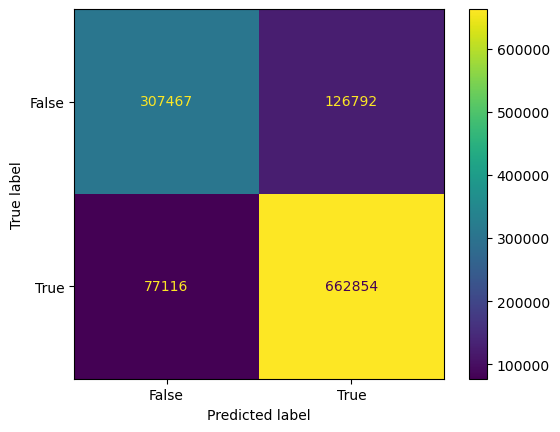

AUC: 0.8929104417334127


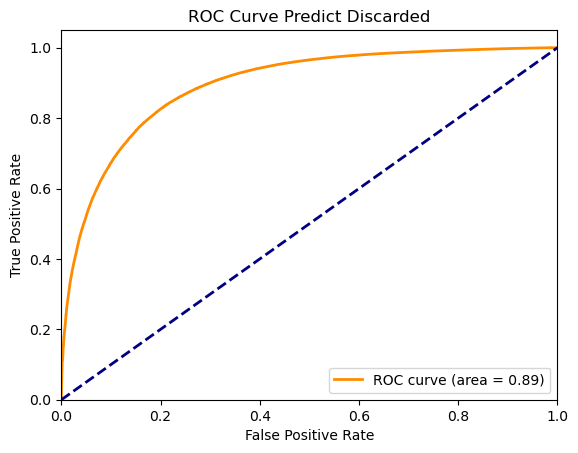

In [17]:
#Train the lightgbm model

model_top=lgb.LGBMClassifier(eval_metric='auc',objective='binary', n_jobs=-1)
model_top.fit(X_train,y_train,categorical_feature=binary_columns_Xtest)

#Make predictions on the test set
y_pred_top=model_top.predict(X_test)
y_pred_prob_top=model_top.predict_proba(X_test)[:,1]

#Evaluate the model
accuracy_top = accuracy_score(y_test, y_pred_top)
print(f"Accuracy: {accuracy_top}")

#print classification report
print(classification_report(y_test, y_pred_top))

#print confusion matrix
cm_top=confusion_matrix(y_test,y_pred_top)
print(cm_top)

# Visualize the confusion matrix with adjusted font size
plt.figure(figsize=(8, 6))
cmdisplay=ConfusionMatrixDisplay(confusion_matrix=cm_top,display_labels=model_top.classes_)
cmdisplay.plot()
plt.show()


# Calculate AUC and plot ROC curve
auc_top = roc_auc_score(y_test, y_pred_prob_top)
fpr_top, tpr_top, thresholds_top = roc_curve(y_test, y_pred_prob_top)

print(f"AUC: {auc_top}")

plt.figure()
plt.plot(fpr_top, tpr_top, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_top)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Predict Discarded')
plt.legend(loc="lower right")
plt.show()

# Second Layer of Hierarchical model- Question vs Non-Question


In [18]:
#Second lv classification: Question vs Non-Question
non_discarded_indices= test_set.index[~y_pred_top]
X_test_non_discarded = X_test.loc[non_discarded_indices]
y_test_non_discarded = test_set.loc[non_discarded_indices]['target_question']

X_train_non_discarded = train_set.loc[train_set['target_discarded']!= True].drop(columns =excluded_columns_subtarget)
y_train_non_discarded = train_set.loc[train_set['target_discarded']!= True]['target_question']


In [19]:
import imblearn


In [20]:
## oversample the minor class for training, use the original test set for testing
oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority')
X_train_over2, y_train_over2 = oversample.fit_resample(X_train_non_discarded, y_train_non_discarded)

In [21]:
binary_columns_Xtrain_second = detect_binary_columns(X_train_over2)
binary_columns_Xtest_second = detect_binary_columns(X_test_non_discarded)
binary_columns_Xtest_second.append('style')
binary_columns_Xtrain_second.append('style')

for col in binary_columns_Xtrain_second:
    X_train_over2[col] =X_train_over2[col].astype('category')
for col in binary_columns_Xtest_second:
    X_test_non_discarded[col] = X_test_non_discarded[col].astype('category')


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 1365471, number of negative: 1365471
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.304741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8912
[LightGBM] [Info] Number of data points in the train set: 2730942, number of used features: 91
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
Second Level Accuracy (Question vs. Non-Question): 0

<Figure size 800x600 with 0 Axes>

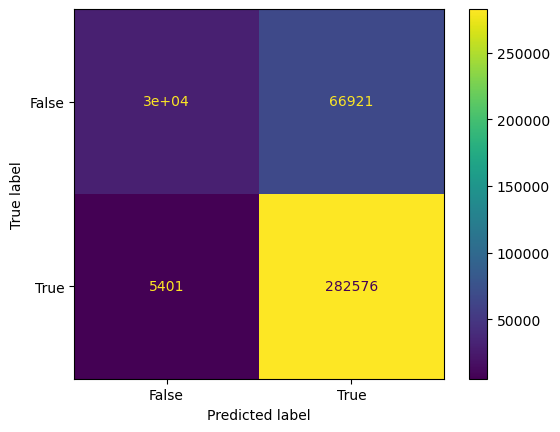

AUC: 0.7614089337584082


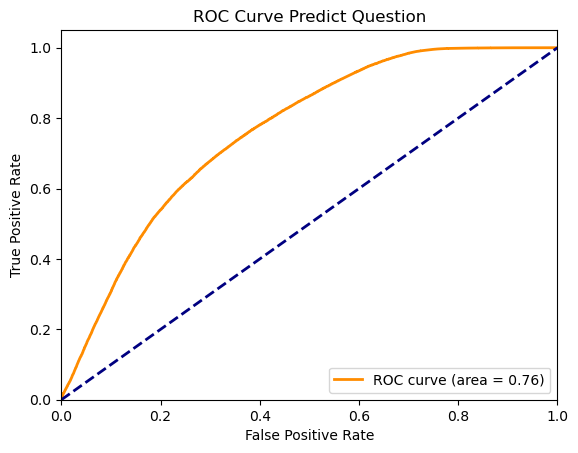

In [22]:
# Second-level classification model building # F1 score

model_second =lgb.LGBMClassifier(eval_metric='auc',objective='binary', n_jobs=-1)
model_second.fit(X_train_over2, y_train_over2, categorical_feature=binary_columns_Xtest_second)
y_pred_second = model_second.predict(X_test_non_discarded)
y_pred_prob_second=model_second.predict_proba(X_test_non_discarded)[:,1]
accuracy_second = accuracy_score(y_test_non_discarded,y_pred_second)
print(f"Second Level Accuracy (Question vs. Non-Question): {accuracy_second}")
print("Second Level Classification Report (Question vs. Non-Question):")
print(classification_report(y_test_non_discarded, y_pred_second))


#print confusion matrix
cm_second=confusion_matrix(y_test_non_discarded,y_pred_second)
print(cm_second)

# Visualize the confusion matrix with adjusted font size
plt.figure(figsize=(8, 6))
cmdisplay_second=ConfusionMatrixDisplay(confusion_matrix=cm_second,display_labels=model_second.classes_)
cmdisplay_second.plot()
plt.show()


# Calculate AUC and plot ROC curve
auc_second = roc_auc_score(y_test_non_discarded, y_pred_prob_second)
fpr_second, tpr_second, thresholds_second = roc_curve(y_test_non_discarded, y_pred_prob_second)

print(f"AUC: {auc_second}")

plt.figure()
plt.plot(fpr_second, tpr_second, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_second)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Predict Question')
plt.legend(loc="lower right")
plt.show()

# Third layer of Hierarchical Model subsection vs section

In [23]:
# Prepare the testing set for the third layer
non_question_indices_non_discarded= X_test_non_discarded.index[y_pred_second == 0]
X_test_non_question = X_test_non_discarded.loc[non_question_indices_non_discarded]
y_test_non_question = test_set.loc[non_question_indices_non_discarded]['target_section']
print(X_test_non_question.shape)
print(y_test_non_question)

(35086, 91)
258109      True
258110      True
258111      True
258112      True
258113      True
           ...  
5135276    False
5135291    False
5135296    False
5135305    False
5135312    False
Name: target_section, Length: 35086, dtype: bool


In [24]:
#Third lv classification: Section vs non section (subsection)
X_train_non_question = train_set.loc[(train_set['target_question']!= True)&(train_set['target_discarded']!=True)].drop(columns =excluded_columns_subtarget)
y_train_non_question = train_set.loc[(train_set['target_question']!=True)&(train_set['target_discarded']!=True)]['target_section']

In [25]:
## oversample the minor class for training, use the original test set for testing
oversample_3 = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority')
X_train_over_3, y_train_over_3 = oversample.fit_resample(X_train_non_question, y_train_non_question)

In [26]:
binary_columns_Xtrain_third = detect_binary_columns(X_train_over_3)
binary_columns_Xtest_third = detect_binary_columns(X_test_non_question)
binary_columns_Xtest_third.append('style')
binary_columns_Xtrain_third.append('style')

for col in binary_columns_Xtrain_third:
    X_train_over_3[col] =X_train_over_3[col].astype('category')
for col in binary_columns_Xtest_third:
    X_test_non_question[col] = X_test_non_question[col].astype('category')


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 112126, number of negative: 112126
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9328
[LightGBM] [Info] Number of data points in the train set: 224252, number of used features: 90
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
Third Level Accuracy (Section vs. Subsection): 0.661944

<Figure size 800x600 with 0 Axes>

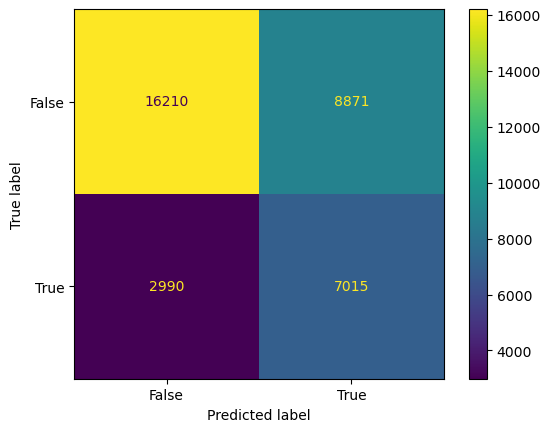

AUC: 0.7312694994155967


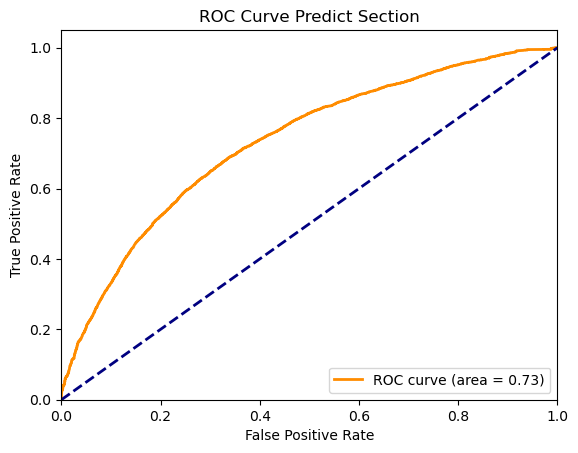

In [27]:
# Third-level classification model building
model_third =lgb.LGBMClassifier(eval_metric='auc',objective='binary', n_jobs=-1)
model_third.fit(X_train_over_3, y_train_over_3, categorical_feature=binary_columns_Xtest_third)
y_pred_third = model_third.predict(X_test_non_question)
y_pred_prob_third=model_third.predict_proba(X_test_non_question)[:,1]
accuracy_third = accuracy_score(y_test_non_question,y_pred_third)
print(f"Third Level Accuracy (Section vs. Subsection): {accuracy_third}")
print("Third Level Classification Report (section vs. subsection):")
print(classification_report(y_test_non_question, y_pred_third))


#print confusion matrix
cm_third=confusion_matrix(y_test_non_question,y_pred_third)
print(cm_third)

# Visualize the confusion matrix with adjusted font size
plt.figure(figsize=(8, 6))
cmdisplay_third=ConfusionMatrixDisplay(confusion_matrix=cm_third,display_labels=model_third.classes_)
cmdisplay_third.plot()
plt.show()


# Calculate AUC and plot ROC curve
auc_third = roc_auc_score(y_test_non_question, y_pred_prob_third)
fpr_third, tpr_third, thresholds_third = roc_curve(y_test_non_question, y_pred_prob_third)

print(f"AUC: {auc_third}")

plt.figure()
plt.plot(fpr_third, tpr_third, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_third)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Predict Section')
plt.legend(loc="lower right")
plt.show()

# Data Preprocessing for PCA and duplicate-free dataset

In [28]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit

In [29]:
# Load unique index
indices_df=pd.read_csv('unique_indexes.csv')
unique_index=indices_df['unique_index'].values

In [30]:
# Apply unique index to original data with dummies
df_filtered= df_encoded_OHtarget.loc[unique_index]

In [31]:
print(df_filtered.columns)

Index(['css_pk', 'customer_pk', 'is_italic', 'is_bold', 'html_pk', 'id',
       'is_underline', 'form_rel_depth', 'form_rel_font_size',
       'form_font_family_mode_ind', 'form_font_colour_mode_ind',
       'lang_num_sents', 'lang_num_words', 'lang_mean_words_per_sent',
       'lang_ls_alnum', 'lang_ls_qm', 'lang_ls_fs', 'lang_ls_clscl',
       'lang_ls_brkt', 'para_prec_bold_ind', 'para_foll_bold_ind',
       'para_prec_italic_ind', 'para_foll_italic_ind',
       'para_prec_underline_ind', 'para_foll_underline_ind',
       'para_prec_font_ind', 'para_foll_font_ind', 'para_prec_colour_ind',
       'para_foll_colour_ind', 'is_upper', 'is_title', 'style', 'style_bullet',
       'style_table', 'style_list_num', 'style_heading', 'style_box',
       'style_toc', 'style_q', 'style_ans', 'style_title', 'style_indent',
       'style_cover_nm_add', 'style_head_foot',
       'lang_pct_coordinating_conjunction', 'lang_pct_cardinal_digit',
       'lang_pct_determiner', 'lang_pct_existential_there

In [32]:
# Perform PCA
numeric_cols=[col for col in df_filtered.columns if col not in categorical_cols +['target', 'css_pk', 'customer_pk', 'html_pk','id','style','target_question','target_subsection','target_discarded','target_section']]

In [33]:
print(len(numeric_cols))

90


In [34]:
# Standardize the numeric features
scaler=StandardScaler()
df_scaled= scaler.fit_transform(df_filtered[numeric_cols])

In [35]:
#Apple PCA
pca=PCA()
pca.fit(df_scaled)

PCA()

In [36]:
# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

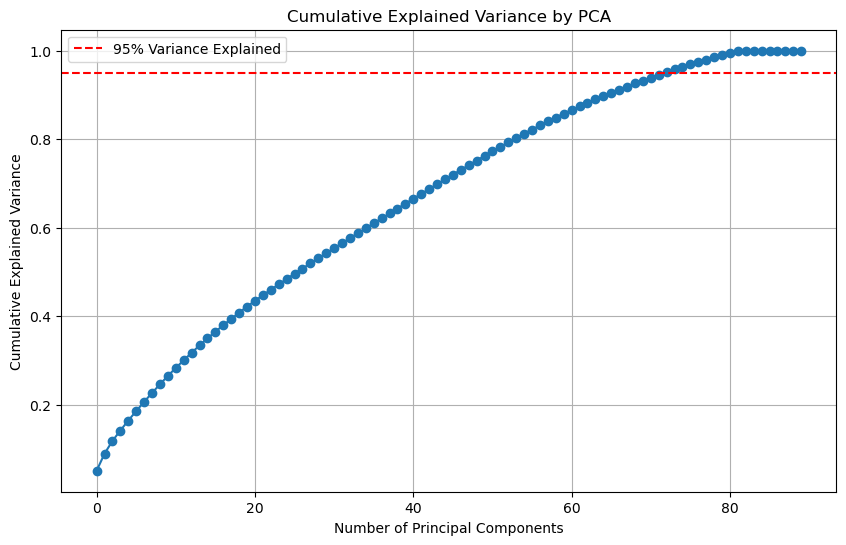

Optimal number of components to explain 95% variance: 73


In [37]:
# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Explained')
plt.legend(loc='best')
plt.show()

# Determine the optimal number of components
optimal_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
print(f'Optimal number of components to explain 95% variance: {optimal_components}')

In [38]:
#Apply PCA with optimal # of PC
pca_optimal = PCA(n_components=optimal_components)
pca_components = pca_optimal.fit_transform(df_scaled)
pca_columns = [f'pca_{i}' for i in range(pca_components.shape[1])]
df_pca = pd.DataFrame(pca_components, columns=pca_columns, index=df_filtered.index)


In [39]:
df_pca.shape

(3136026, 73)

In [40]:
#Combine PCA with categorical variable
# 1. Define categorical and target columns
categorical_cols = ['begins_with', 'para_foll_depth_ind', 'para_foll_size_ind', 'para_prec_depth_ind', 'para_prec_size_ind']
target_cols = ['target', 'target_question', 'target_subsection', 'target_discarded', 'target_section']
other_cols = ['css_pk', 'customer_pk', 'html_pk', 'id', 'style']

df_combined= pd.concat([df_pca,df_filtered[target_cols],df_filtered[other_cols]], axis=1)

In [41]:
df_combined.shape

(3136026, 83)

In [42]:
# Filter customers with less than 2 css_pk
customers_with_less_than2_csspk = [
    x for x in df_combined['customer_pk'].unique() 
    if len(df_combined[df_combined['customer_pk'] == x]['css_pk'].unique()) < 2
]
filtered_df = df_combined[~df_combined['customer_pk'].isin(customers_with_less_than2_csspk)]

# Initialize GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=42)

# Lists to store train and test data
train_list = []
test_list = []

# Perform train-test split within each group
for i in filtered_df['customer_pk'].unique():
    X = filtered_df.loc[filtered_df['customer_pk'] == i]
    train_index, test_index = next(gss.split(X, groups=X['css_pk']))
    
    # Append the subset data to the respective list
    train_list.append(X.iloc[train_index])
    test_list.append(X.iloc[test_index])

# Concatenate the lists to create final train and test DataFrames
train_df = pd.concat(train_list, ignore_index=True)
test_df = pd.concat(test_list, ignore_index=True)

print(f"Train DataFrame length: {len(train_df)}")
print(f"Test DataFrame length: {len(test_df)}")

Train DataFrame length: 2443137
Test DataFrame length: 676073


In [43]:
# save npy to folder
np.save('filtered_train_split_index.npy',np.array(train_df.index))
np.save('filtered_test_split_index.npy',np.array(test_df.index))

# Model Building: Hierarchical (Question vs Non-Question)- First layer- Original variables & duplicate free model

In [44]:
print(df_filtered.shape)

(3136026, 100)


In [45]:
excluded_columns=['css_pk','customer_pk','html_pk','id']
excluded_columns_target=['target','target_question','target_section','target_discarded','target_subsection']
df_filtered= df_filtered.drop(columns=excluded_columns)

In [46]:
# load the indices
train_indices= np.load('filtered_train_split_index.npy')
test_indices= np.load('filtered_test_split_index.npy')

In [47]:
print(f"Max index in train_indices: {max(train_indices)}")
print(f"Max index in test_indices: {max(test_indices)}")
print(f"DataFrame length: {len(df_filtered)}")


Max index in train_indices: 2443136
Max index in test_indices: 676072
DataFrame length: 3136026


In [48]:
# apply the indices to create training and testing sets
train_set =df_filtered.iloc[train_indices]
test_set=df_filtered.iloc[test_indices]

In [49]:

print(train_set.shape)
print(test_set.shape)

(2443137, 96)
(676073, 96)


In [50]:
#configure training and testing for model
X_train=train_set.drop(columns=excluded_columns_target)
y_train=train_set['target_question']
X_test= test_set.drop(columns=excluded_columns_target)
y_test=test_set['target_question']

In [51]:
X_train.columns

Index(['is_italic', 'is_bold', 'is_underline', 'form_rel_depth',
       'form_rel_font_size', 'form_font_family_mode_ind',
       'form_font_colour_mode_ind', 'lang_num_sents', 'lang_num_words',
       'lang_mean_words_per_sent', 'lang_ls_alnum', 'lang_ls_qm', 'lang_ls_fs',
       'lang_ls_clscl', 'lang_ls_brkt', 'para_prec_bold_ind',
       'para_foll_bold_ind', 'para_prec_italic_ind', 'para_foll_italic_ind',
       'para_prec_underline_ind', 'para_foll_underline_ind',
       'para_prec_font_ind', 'para_foll_font_ind', 'para_prec_colour_ind',
       'para_foll_colour_ind', 'is_upper', 'is_title', 'style', 'style_bullet',
       'style_table', 'style_list_num', 'style_heading', 'style_box',
       'style_toc', 'style_q', 'style_ans', 'style_title', 'style_indent',
       'style_cover_nm_add', 'style_head_foot',
       'lang_pct_coordinating_conjunction', 'lang_pct_cardinal_digit',
       'lang_pct_determiner', 'lang_pct_existential_there',
       'lang_pct_foreign_word',
       'lang_p

In [52]:

binary_columns_Xtrain = detect_binary_columns(X_train)
binary_columns_Xtest = detect_binary_columns(X_test)
binary_columns_Xtest.append('style')
binary_columns_Xtrain.append('style')

for col in binary_columns_Xtrain:
    X_train[col] =X_train[col].astype('category')
for col in binary_columns_Xtest:
    X_test[col] = X_test[col].astype('category')

In [53]:
## oversample the minor class for training, use the original test set for testing
oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority')
X_train, y_train = oversample.fit_resample(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 1300287, number of negative: 1300287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.302680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9036
[LightGBM] [Info] Number of data points in the train set: 2600574, number of used features: 91
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
Accuracy: 0.8305671133146865
              precision

<Figure size 800x600 with 0 Axes>

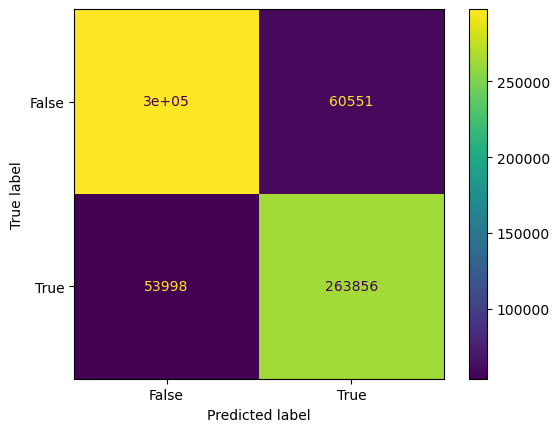

AUC: 0.9083165268057685


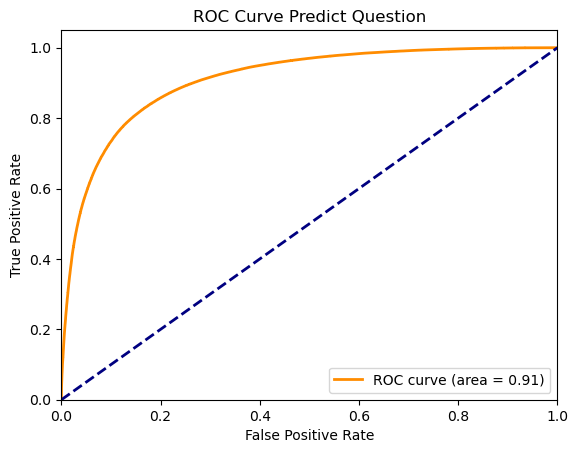

In [54]:
#Train the lightgbm model

model=lgb.LGBMClassifier(eval_metric='auc',objective='binary', n_jobs=-1)
model.fit(X_train,y_train,categorical_feature=binary_columns_Xtest)

#Make predictions on the test set
y_pred=model.predict(X_test)
y_pred_prob=model.predict_proba(X_test)[:,1]

#Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

#print classification report
print(classification_report(y_test, y_pred))

#print confusion matrix
cm=confusion_matrix(y_test,y_pred)
print(cm)

# Visualize the confusion matrix with adjusted font size
plt.figure(figsize=(8, 6))
cmdisplay=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
cmdisplay.plot()
plt.show()


# Calculate AUC and plot ROC curve
auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

print(f"AUC: {auc}")

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Predict Question')
plt.legend(loc="lower right")
plt.show()

# Model Building: Hierarchical (Discarded vs Non-discarded)- Second layer- Original variables & duplicate free model

In [55]:
#configure training and testing for model
X_train=train_set.drop(columns=excluded_columns_target)
y_train=train_set['target_discarded']
X_test= test_set.drop(columns= excluded_columns_target)
y_test=test_set['target_discarded']

In [56]:
#Second lv classification: discarded vs non-discarded
non_question_indices= test_set.index[~y_pred]
X_test = X_test.loc[non_question_indices]
y_test = test_set.loc[non_question_indices]['target_discarded']

X_train = train_set.loc[train_set['target_question']!= True].drop(columns =excluded_columns_target)
y_train = train_set.loc[train_set['target_question']!= True]['target_discarded']

In [57]:
## oversample the minor class for training, use the original test set for testing
oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority')
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [58]:

binary_columns_Xtrain = detect_binary_columns(X_train)
binary_columns_Xtest = detect_binary_columns(X_test)
binary_columns_Xtest.append('style')
binary_columns_Xtrain.append('style')

for col in binary_columns_Xtrain:
    X_train[col] =X_train[col].astype('category')
for col in binary_columns_Xtest:
    X_test[col] = X_test[col].astype('category')

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 1218828, number of negative: 1218828
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.290252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9383
[LightGBM] [Info] Number of data points in the train set: 2437656, number of used features: 91
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
Accuracy: 0.749355922949617
              precision 

<Figure size 800x600 with 0 Axes>

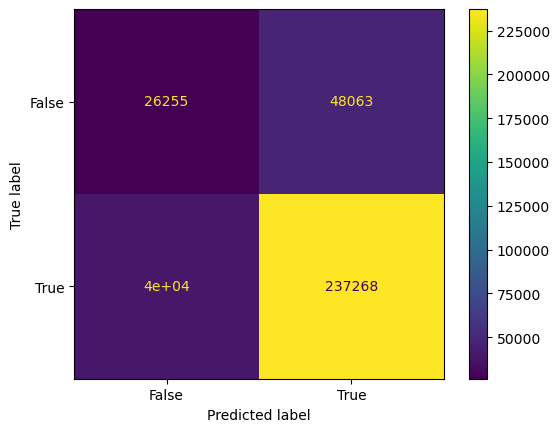

AUC: 0.6585159781960147


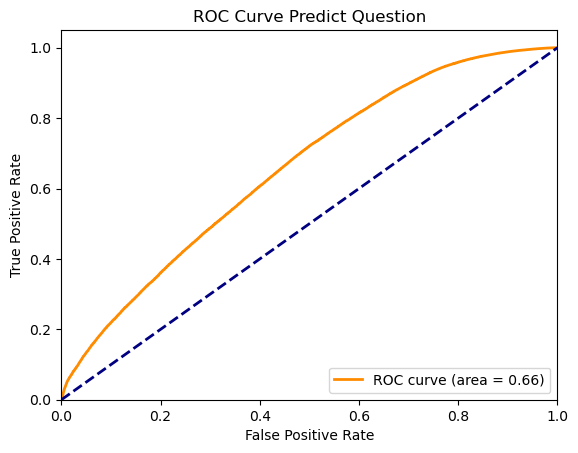

In [59]:
#Train the lightgbm model

model=lgb.LGBMClassifier(eval_metric='auc',objective='binary', n_jobs=-1)
model.fit(X_train,y_train,categorical_feature=binary_columns_Xtest)

#Make predictions on the test set
y_pred=model.predict(X_test)
y_pred_prob=model.predict_proba(X_test)[:,1]

#Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

#print classification report
print(classification_report(y_test, y_pred))

#print confusion matrix
cm=confusion_matrix(y_test,y_pred)
print(cm)

# Visualize the confusion matrix with adjusted font size
plt.figure(figsize=(8, 6))
cmdisplay=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
cmdisplay.plot()
plt.show()


# Calculate AUC and plot ROC curve
auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

print(f"AUC: {auc}")

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Predict Question')
plt.legend(loc="lower right")
plt.show()

# Model Building: Hierarchical (Section vs Non-section (subsection))- Third layer- Original variables & duplicate free model

In [60]:
#Third lv classification: Section vs Non Section (Subsection)
# Prepare the testing set for the third layer
non_question_indices_non_discarded= X_test.index[y_pred == 0]
X_test = X_test.loc[non_question_indices_non_discarded]
y_test = test_set.loc[non_question_indices_non_discarded]['target_section']
print(X_test_non_question.shape)
print(y_test_non_question)

(35086, 91)
258109      True
258110      True
258111      True
258112      True
258113      True
           ...  
5135276    False
5135291    False
5135296    False
5135305    False
5135312    False
Name: target_section, Length: 35086, dtype: bool


In [61]:
#Third lv classification: Section vs non section (subsection)
X_train = train_set.loc[(train_set['target_question']!= True)&(train_set['target_discarded']!=True)].drop(columns =excluded_columns_target)
y_train = train_set.loc[(train_set['target_question']!=True)&(train_set['target_discarded']!=True)]['target_section']

In [62]:
## oversample the minor class for training, use the original test set for testing
oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority')
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [63]:

binary_columns_Xtrain = detect_binary_columns(X_train)
binary_columns_Xtest = detect_binary_columns(X_test)
binary_columns_Xtest.append('style')
binary_columns_Xtrain.append('style')

for col in binary_columns_Xtrain:
    X_train[col] =X_train[col].astype('category')
for col in binary_columns_Xtest:
    X_test[col] = X_test[col].astype('category')

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 46280, number of negative: 46280
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5650
[LightGBM] [Info] Number of data points in the train set: 92560, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
Accuracy: 0.6028190246476219
              precision    re

<Figure size 800x600 with 0 Axes>

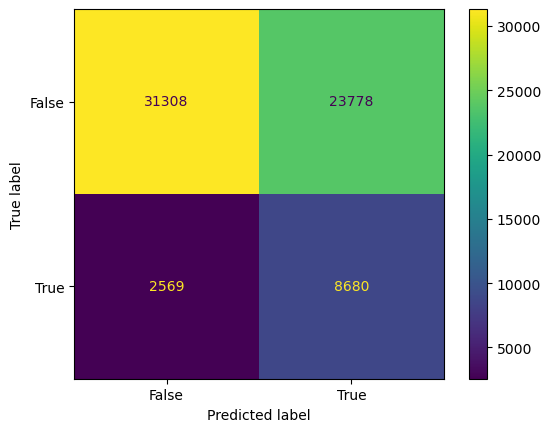

AUC: 0.7270778972887648


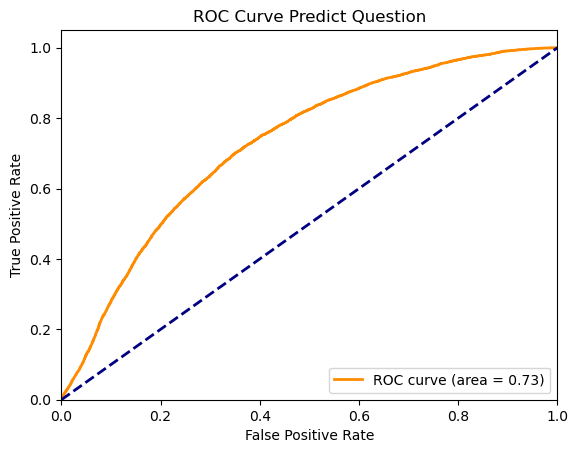

In [64]:
#Train the lightgbm model

model=lgb.LGBMClassifier(eval_metric='auc',objective='binary', n_jobs=-1)
model.fit(X_train,y_train,categorical_feature=binary_columns_Xtest)

#Make predictions on the test set
y_pred=model.predict(X_test)
y_pred_prob=model.predict_proba(X_test)[:,1]

#Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

#print classification report
print(classification_report(y_test, y_pred))

#print confusion matrix
cm=confusion_matrix(y_test,y_pred)
print(cm)

# Visualize the confusion matrix with adjusted font size
plt.figure(figsize=(8, 6))
cmdisplay=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
cmdisplay.plot()
plt.show()


# Calculate AUC and plot ROC curve
auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

print(f"AUC: {auc}")

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Predict Question')
plt.legend(loc="lower right")
plt.show()

In [65]:
print(df_filtered.shape)

(3136026, 96)


# Model Building: Hierarchical (Discarded vs Non-discarded)- First layer- PCA & duplicate free model

In [79]:
excluded_columns=['css_pk','customer_pk','html_pk','id']
excluded_columns_target=['target','target_question','target_section','target_discarded','target_subsection']
df_enhance_1= df_combined.drop(columns=excluded_columns+excluded_columns_target)
df_enhance_1['target_question']=df_combined['target_question']
df_enhance_1['target_discarded']=df_combined['target_discarded']
df_enhance_1['target_section']=df_combined['target_section']
df_enhance_1['target_subsection']=df_combined['target_subsection']

In [80]:
df_enhance_1.shape

(3136026, 78)

In [81]:
# load the indices
train_indices= np.load('filtered_train_split_index.npy')
test_indices= np.load('filtered_test_split_index.npy')

In [69]:
train_indices.shape

(2443137,)

In [70]:
test_indices.shape

(676073,)

In [82]:
print(f"Max index in train_indices: {max(train_indices)}")
print(f"Max index in test_indices: {max(test_indices)}")
print(f"DataFrame length: {len(df_enhance_1)}")


Max index in train_indices: 2443136
Max index in test_indices: 676072
DataFrame length: 3136026


In [83]:
# apply the indices to create training and testing sets
train_set =df_enhance_1.iloc[train_indices]
test_set=df_enhance_1.iloc[test_indices]

In [84]:

print(train_set.shape)
print(test_set.shape)

(2443137, 78)
(676073, 78)


In [86]:
#configure training and testing for model
X_train=train_set.drop(columns=excluded_columns_subtarget)
y_train=train_set['target_discarded']
X_test= test_set.drop(columns=excluded_columns_subtarget)
y_test=test_set['target_discarded']

In [87]:
train_set.columns

Index(['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7',
       'pca_8', 'pca_9', 'pca_10', 'pca_11', 'pca_12', 'pca_13', 'pca_14',
       'pca_15', 'pca_16', 'pca_17', 'pca_18', 'pca_19', 'pca_20', 'pca_21',
       'pca_22', 'pca_23', 'pca_24', 'pca_25', 'pca_26', 'pca_27', 'pca_28',
       'pca_29', 'pca_30', 'pca_31', 'pca_32', 'pca_33', 'pca_34', 'pca_35',
       'pca_36', 'pca_37', 'pca_38', 'pca_39', 'pca_40', 'pca_41', 'pca_42',
       'pca_43', 'pca_44', 'pca_45', 'pca_46', 'pca_47', 'pca_48', 'pca_49',
       'pca_50', 'pca_51', 'pca_52', 'pca_53', 'pca_54', 'pca_55', 'pca_56',
       'pca_57', 'pca_58', 'pca_59', 'pca_60', 'pca_61', 'pca_62', 'pca_63',
       'pca_64', 'pca_65', 'pca_66', 'pca_67', 'pca_68', 'pca_69', 'pca_70',
       'pca_71', 'pca_72', 'style', 'target_question', 'target_discarded',
       'target_section', 'target_subsection'],
      dtype='object')

In [88]:
X_train['style']=X_train['style'].astype('category')
X_test['style']=X_test['style'].astype('category')

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 1218828, number of negative: 1224309
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.216281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19904
[LightGBM] [Info] Number of data points in the train set: 2443137, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498878 -> initscore=-0.004487
[LightGBM] [Info] Start training from score -0.004487
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
Accuracy: 0.7892964221319295
Precision: 0.7758471786364763
R

<Figure size 800x600 with 0 Axes>

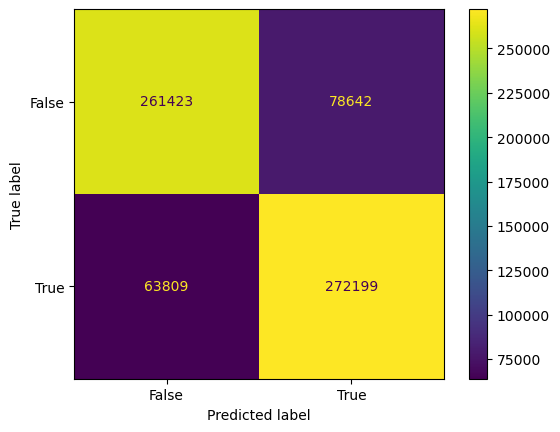

AUC: 0.8705945152179368


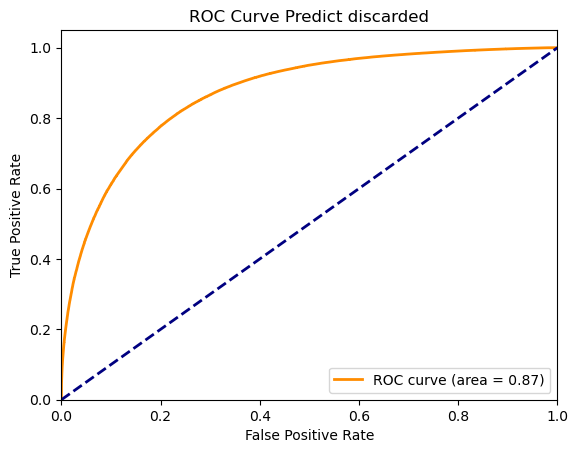

In [89]:
#Train the lightgbm model

model=lgb.LGBMClassifier(eval_metric='auc',objective='binary', n_jobs=-1)
model.fit(X_train,y_train,categorical_feature=['style'])

#Make predictions on the test set
y_pred=model.predict(X_test)
y_pred_prob=model.predict_proba(X_test)[:,1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"AUC: {auc}")


#print classification report
print(classification_report(y_test, y_pred))

#print confusion matrix
cm=confusion_matrix(y_test,y_pred)
print(cm)

# Visualize the confusion matrix with adjusted font size
plt.figure(figsize=(8, 6))
cmdisplay=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
cmdisplay.plot()
plt.show()


# Calculate AUC and plot ROC curve
auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

print(f"AUC: {auc}")

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Predict discarded')
plt.legend(loc="lower right")
plt.show()

# Second Layer of Hierarchical model- question vs non-question

In [90]:
df_combined.columns

Index(['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7',
       'pca_8', 'pca_9', 'pca_10', 'pca_11', 'pca_12', 'pca_13', 'pca_14',
       'pca_15', 'pca_16', 'pca_17', 'pca_18', 'pca_19', 'pca_20', 'pca_21',
       'pca_22', 'pca_23', 'pca_24', 'pca_25', 'pca_26', 'pca_27', 'pca_28',
       'pca_29', 'pca_30', 'pca_31', 'pca_32', 'pca_33', 'pca_34', 'pca_35',
       'pca_36', 'pca_37', 'pca_38', 'pca_39', 'pca_40', 'pca_41', 'pca_42',
       'pca_43', 'pca_44', 'pca_45', 'pca_46', 'pca_47', 'pca_48', 'pca_49',
       'pca_50', 'pca_51', 'pca_52', 'pca_53', 'pca_54', 'pca_55', 'pca_56',
       'pca_57', 'pca_58', 'pca_59', 'pca_60', 'pca_61', 'pca_62', 'pca_63',
       'pca_64', 'pca_65', 'pca_66', 'pca_67', 'pca_68', 'pca_69', 'pca_70',
       'pca_71', 'pca_72', 'target', 'target_question', 'target_subsection',
       'target_discarded', 'target_section', 'css_pk', 'customer_pk',
       'html_pk', 'id', 'style'],
      dtype='object')

In [91]:
# apply the indices to create training and testing sets
train_set =df_enhance_1.iloc[train_indices]
test_set=df_enhance_1.iloc[test_indices]

In [92]:
#configure training and testing for model
X_train=train_set.drop(columns=excluded_columns_subtarget)
y_train=train_set['target_question']
X_test= test_set.drop(columns= excluded_columns_subtarget)
y_test=test_set['target_question']

In [93]:
#Second lv classification: discarded vs non-discarded
non_question_indices= test_set.index[~y_pred]
X_test = X_test.loc[non_question_indices]
y_test = test_set.loc[non_question_indices]['target_question']

X_train = train_set.loc[train_set['target_discarded']!= True].drop(columns =excluded_columns_subtarget)
y_train = train_set.loc[train_set['target_discarded']!= True]['target_question']

In [61]:
# oversample the minor class for training, use the original test set for testing
# oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority')
# X_train, y_train = oversample.fit_resample(X_train, y_train)

In [94]:
#Convert style to categorical
X_test['style']=X_test['style'].astype('category')
X_train['style']=X_train['style'].astype('category')

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 1142850, number of negative: 81459
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19243
[LightGBM] [Info] Number of data points in the train set: 1224309, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.933465 -> initscore=2.641181
[LightGBM] [Info] Start training from score 2.641181
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
Accuracy: 0.8058862596546466
              precision    recall  

<Figure size 800x600 with 0 Axes>

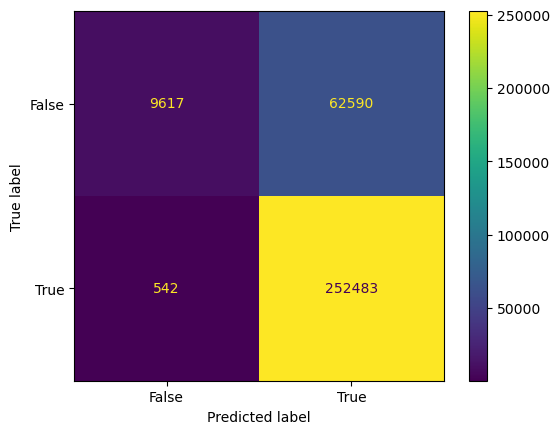

AUC: 0.7138837308173904


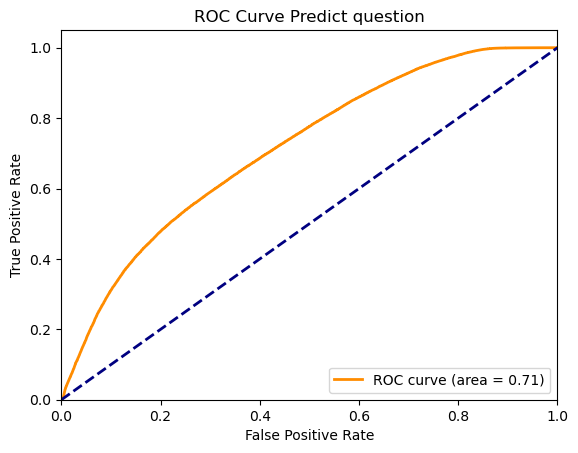

In [95]:
#Train the lightgbm model

model=lgb.LGBMClassifier(eval_metric='auc',objective='binary', n_jobs=-1)
model.fit(X_train,y_train,categorical_feature=['style'])

#Make predictions on the test set
y_pred=model.predict(X_test)
y_pred_prob=model.predict_proba(X_test)[:,1]

#Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

#print classification report
print(classification_report(y_test, y_pred))

#print confusion matrix
cm=confusion_matrix(y_test,y_pred)
print(cm)

# Visualize the confusion matrix with adjusted font size
plt.figure(figsize=(8, 6))
cmdisplay=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
cmdisplay.plot()
plt.show()


# Calculate AUC and plot ROC curve
auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

print(f"AUC: {auc}")

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Predict question')
plt.legend(loc="lower right")
plt.show()

# Third layer of Enhanced hierarchical model- Section vs non Section (Subsection)

In [96]:
#Third lv classification: Section vs Non Section (Subsection)
# Prepare the testing set for the third layer
non_question_indices_non_discarded= X_test.index[y_pred == 0]
X_test = X_test.loc[non_question_indices_non_discarded]
y_test = test_set.loc[non_question_indices_non_discarded]['target_section']
print(X_test_non_question.shape)
print(y_test_non_question)

(35086, 91)
258109      True
258110      True
258111      True
258112      True
258113      True
           ...  
5135276    False
5135291    False
5135296    False
5135305    False
5135312    False
Name: target_section, Length: 35086, dtype: bool


In [97]:
#Third lv classification: Section vs non section (subsection)
X_train = train_set.loc[(train_set['target_question']!= True)&(train_set['target_discarded']!=True)].drop(columns =excluded_columns_subtarget)
y_train = train_set.loc[(train_set['target_question']!=True)&(train_set['target_discarded']!=True)]['target_section']

In [66]:
# oversample the minor class for training, use the original test set for testing
# oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority')
# X_train, y_train = oversample.fit_resample(X_train, y_train)

In [98]:
#Convert style to categorical
X_test['style']=X_test['style'].astype('category')
X_train['style']=X_train['style'].astype('category')

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 46280, number of negative: 35179
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19183
[LightGBM] [Info] Number of data points in the train set: 81459, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568139 -> initscore=0.274261
[LightGBM] [Info] Start training from score 0.274261
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
Accuracy: 0.5901171375135348
              precision    recall  f1-s

<Figure size 800x600 with 0 Axes>

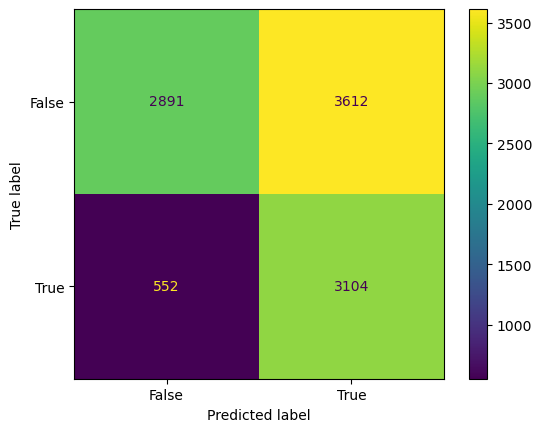

AUC: 0.7278672257308612


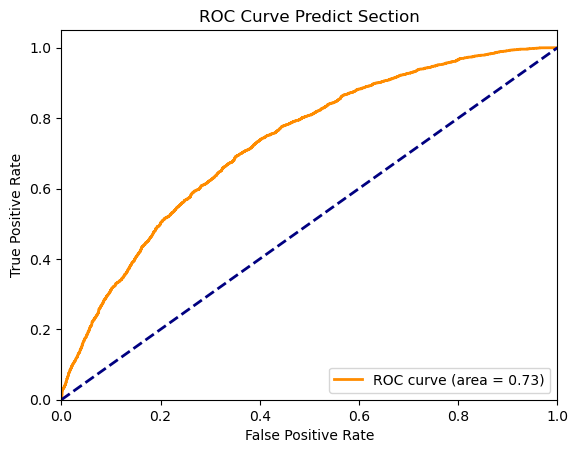

In [99]:
#Train the lightgbm model

model=lgb.LGBMClassifier(eval_metric='auc',objective='binary', n_jobs=-1)
model.fit(X_train,y_train,categorical_feature=['style'])

#Make predictions on the test set
y_pred=model.predict(X_test)
y_pred_prob=model.predict_proba(X_test)[:,1]

#Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

#print classification report
print(classification_report(y_test, y_pred))

#print confusion matrix
cm=confusion_matrix(y_test,y_pred)
print(cm)

# Visualize the confusion matrix with adjusted font size
plt.figure(figsize=(8, 6))
cmdisplay=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
cmdisplay.plot()
plt.show()


# Calculate AUC and plot ROC curve
auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

print(f"AUC: {auc}")

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Predict Section')
plt.legend(loc="lower right")
plt.show()

# SVM Model Building with filtered dataset and PCA

In [78]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [79]:
excluded_columns=['css_pk','customer_pk','html_pk','id']
excluded_columns_target=['target','target_question','target_section','target_discarded','target_subsection']
df_enhance_1= df_combined.drop(columns=excluded_columns+excluded_columns_target)
df_enhance_1['target_question']=df_combined['target_question']

In [71]:
# load the indices
train_indices= np.load('filtered_train_split_index.npy')
test_indices= np.load('filtered_test_split_index.npy')

In [72]:
print(f"Max index in train_indices: {max(train_indices)}")
print(f"Max index in test_indices: {max(test_indices)}")
print(f"DataFrame length: {len(df_enhance_1)}")

Max index in train_indices: 2443136
Max index in test_indices: 676072
DataFrame length: 3136026


In [73]:
# apply the indices to create training and testing sets
train_set =df_enhance_1.iloc[train_indices]
test_set=df_enhance_1.iloc[test_indices]

In [74]:
print(train_set.shape)
print(test_set.shape)

(2443137, 75)
(676073, 75)


In [75]:
#configure training and testing for model
X_train=train_set.drop(columns=['target_question'])
y_train=train_set['target_question']
X_test= test_set.drop(columns=['target_question'])
y_test=test_set['target_question']


In [77]:
X_train['style']=X_train['style'].astype('category')
X_test['style']=X_test['style'].astype('category')

In [ ]:
X_test.columns

Index(['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7',
       'pca_8', 'pca_9', 'pca_10', 'pca_11', 'pca_12', 'pca_13', 'pca_14',
       'pca_15', 'pca_16', 'pca_17', 'pca_18', 'pca_19', 'pca_20', 'pca_21',
       'pca_22', 'pca_23', 'pca_24', 'pca_25', 'pca_26', 'pca_27', 'pca_28',
       'pca_29', 'pca_30', 'pca_31', 'pca_32', 'pca_33', 'pca_34', 'pca_35',
       'pca_36', 'pca_37', 'pca_38', 'pca_39', 'pca_40', 'pca_41', 'pca_42',
       'pca_43', 'pca_44', 'pca_45', 'pca_46', 'pca_47', 'pca_48', 'pca_49',
       'pca_50', 'pca_51', 'pca_52', 'pca_53', 'pca_54', 'pca_55', 'pca_56',
       'pca_57', 'pca_58', 'pca_59', 'pca_60', 'pca_61', 'pca_62', 'pca_63',
       'pca_64', 'pca_65', 'pca_66', 'pca_67', 'pca_68', 'pca_69', 'pca_70',
       'pca_71', 'pca_72', 'style'],
      dtype='object')

In [87]:
# Drop Categorical Variable Style 
X_train=X_train.drop('style', axis=1)
X_test=X_test.drop('style', axis=1)